In [1]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report

#### Setting up random seeds, device and some constants

In [2]:
seed=42
torch.random.manual_seed(seed)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
DATA_DIR = '../data'
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
TRAIN_RAW_DATA_DIR = os.path.join(RAW_DATA_DIR, 'training_set')
TEST_RAW_DATA_DIR = os.path.join(RAW_DATA_DIR, 'test_set')
MODELS_SAVE_DIR = '../models'

In [ ]:
IMAGE_SIZE = 224
IMAGE_CHANNELS = 3
BATCH_SIZE = 64
PATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4

#### Loading the dataset and visualizing samples

In [6]:
train_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(IMAGE_SIZE),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5] * IMAGE_CHANNELS, [0.5] * IMAGE_CHANNELS)])


test_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(IMAGE_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5] * IMAGE_CHANNELS, [0.5] * IMAGE_CHANNELS)])

In [7]:
train_val_dataset = ImageFolder(TRAIN_RAW_DATA_DIR, transform=train_transform)
test_dataset = ImageFolder(TEST_RAW_DATA_DIR, transform=test_transform)

In [8]:
len(train_val_dataset), len(test_dataset)

(8005, 2023)

In [9]:
train_size = int(0.85 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train, val = random_split(train_val_dataset, [train_size, val_size])

In [10]:
len(train), len(val)

(6804, 1201)

In [11]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

In [12]:
classes = train_val_dataset.classes
label_map = {i: classes[i] for i in range(len(classes))}
label_map

{0: 'cats', 1: 'dogs'}

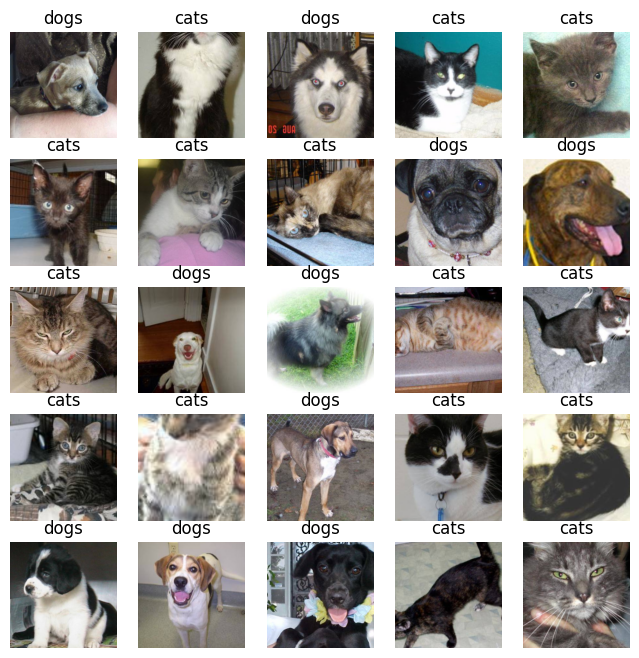

In [16]:
images = next(iter(train_loader))
fig = plt.figure(figsize=(8, 8))
cols, rows = 5, 5

for i in range(0, cols * rows):
    img = images[0][i]
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(torch.permute(img/2+0.5, (1, 2, 0)))
    plt.title(label_map[images[1][i].item()])
    plt.axis('off')

#### Creating a model

In [13]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, embed_dim, image_size, image_channels, patch_size=16):
        '''
        Returns a tensor of a flattened patchified image
        with a cls token and positional embeddings
        with shape (batch_size, num_patches + 1, embed_dim)
        '''
        super().__init__()
        self.patch_size = patch_size
        self.unfold = torch.nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size)
        self.linear = nn.Linear(self.patch_size * self.patch_size * image_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + (image_size**2 // patch_size**2), embed_dim), requires_grad=True)

    def forward(self, x):
        batch_size, c, h, w = x.shape
        assert h % self.patch_size == 0 and w % self.patch_size == 0, 'Image dimensions must be divisible by patch size'
        assert h == w, 'Image must be square'

        x = self.unfold(x).transpose(1, 2)
        x = self.linear(x)
        x = torch.cat((self.cls_token.expand(batch_size, -1, -1), x), dim=1)
        x += self.pos_embedding
        return x

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=12, bias=False):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.wqkv = nn.Linear(embed_dim, embed_dim * 3, bias=bias)
        self.wo = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, num_patches, embed_dim = x.shape

        #shape->(3, batch, heads, num_tokens, head_dim)
        qkv = self.wqkv(x).reshape(batch_size, num_patches, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attention = (q @ k.transpose(-2, -1)) * self.scale
        attention = attention.softmax(dim=-1)

        #(batch, heads, num_tokens, head_dim)->(batch, num_tokens, heads, head_dim)->(batch, num_tokens, embed_dim)
        out = (attention @ v).transpose(1, 2).reshape(batch_size, num_patches, embed_dim)
        out = self.wo(out)
        return out

In [15]:
class MLPBlock(nn.Module):
    def __init__(self, embed_dim, hidden_features, activation=nn.GELU(), dropout=0.):
        super().__init__()

        self.fc1 = nn.Linear(embed_dim, hidden_features)
        self.act = activation
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_features, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [16]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads=12, dropout=0., bias=False):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.mha = MultiHeadAttention(embed_dim, num_heads, bias=bias)
        self.norm2 = nn.LayerNorm(embed_dim)
        #self.mlp = MLPBlock(embed_dim, embed_dim * 4, dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        out1 = self.norm1(x)
        out2 = self.mha(out1)
        x = x + out2
        out1 = self.norm2(x)
        out2 = self.mlp(out1)
        x = x + out2
        return x

In [17]:
class VIT(nn.Module):
    def __init__(self, image_size, image_channels, 
                 patch_size, embed_dim=768, num_heads=12, num_layers=4, num_classes=2, mlp_dropout=0., bias=False):
        super().__init__()
        self.patch_embedding = PatchEmbeddingLayer(embed_dim, image_size, image_channels, patch_size)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(embed_dim, num_heads, mlp_dropout, bias) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.transformer_encoder(x)
        x = self.norm(x)
        x = x[:, 0]
        x = self.classifier(x)
        return x

In [18]:
model = VIT(IMAGE_SIZE, IMAGE_CHANNELS, PATCH_SIZE, embed_dim=768, 
            num_heads=4, num_layers=4, num_classes=len(classes), mlp_dropout=0.1, bias=False).to(device)
model.to(device)

VIT(
  (patch_embedding): PatchEmbeddingLayer(
    (unfold): Unfold(kernel_size=16, dilation=1, padding=0, stride=16)
    (linear): Linear(in_features=768, out_features=768, bias=True)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (wqkv): Linear(in_features=768, out_features=2304, bias=False)
        (wo): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=3072, out_features=768, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoder(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(


In [19]:
summary(model, input_size=(BATCH_SIZE, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
VIT                                      [64, 2]                   --
├─PatchEmbeddingLayer: 1-1               [64, 197, 768]            152,064
│    └─Unfold: 2-1                       [64, 768, 196]            --
│    └─Linear: 2-2                       [64, 196, 768]            590,592
├─Sequential: 1-2                        [64, 197, 768]            --
│    └─TransformerEncoder: 2-3           [64, 197, 768]            --
│    │    └─LayerNorm: 3-1               [64, 197, 768]            1,536
│    │    └─MultiHeadAttention: 3-2      [64, 197, 768]            2,360,064
│    │    └─LayerNorm: 3-3               [64, 197, 768]            1,536
│    │    └─Sequential: 3-4              [64, 197, 768]            4,722,432
│    └─TransformerEncoder: 2-4           [64, 197, 768]            --
│    │    └─LayerNorm: 3-5               [64, 197, 768]            1,536
│    │    └─MultiHeadAttention: 3-6      [64, 197, 7

#### Training the model

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [28]:
def get_accuracy(preds, y):
    predicted = torch.argmax(preds, 1)
    acc = (predicted == y).float().mean()
    return acc

def train_epoch(epoch, model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_acc = 0
    losses = []
    accs = []

    loop = tqdm(data_loader)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        acc = get_accuracy(outputs, labels)
        running_acc += acc.item()
        losses.append(loss.item())
        accs.append(acc.item())
        loop.set_description(f'Epoch [{epoch+1}/{NUM_EPOCHS}]')
        loop.set_postfix(loss=loss.item(), accuracy=acc.item())

    return running_loss / len(data_loader), running_acc / len(data_loader), losses, accs

def val_epoch(epoch, model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0
    losses = []
    accs = []

    loop = tqdm(data_loader)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            acc = get_accuracy(outputs, labels)
            running_acc += acc.item()
            losses.append(loss.item())
            accs.append(acc.item())
            loop.set_description(f'Epoch [{epoch+1}/{NUM_EPOCHS}]')
            loop.set_postfix(loss=running_loss / len(data_loader), accuracy=acc.item())

    return running_loss / len(data_loader), running_acc / len(data_loader), losses, accs

def test_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0
    preds = []
    targets = []
    loop = tqdm(data_loader)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            acc = get_accuracy(outputs, labels)
            running_acc += acc.item()
            loop.set_postfix(loss=running_loss / len(data_loader), accuracy=acc.item())
            preds += torch.argmax(outputs, 1).tolist()
            targets += labels.tolist()

    return running_loss / len(data_loader), running_acc / len(data_loader), preds, targets

In [23]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
steps_train_losses = []
steps_train_accuracies = []
steps_val_losses = []
steps_val_accuracies = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy, steps_train_loss, steps_train_acc = train_epoch(epoch, model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, steps_val_loss, steps_val_acc = val_epoch(epoch, model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    steps_train_losses += steps_train_loss
    steps_train_accuracies += steps_train_acc
    steps_val_losses += steps_val_loss
    steps_val_accuracies += steps_val_acc

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/5]: 100%|██████████| 19/19 [00:29<00:00,  1.58s/it, accuracy=0.408, loss=0.721]


Epoch 1/5, Train Loss: 0.7540, Train Accuracy: 0.5083, Val Loss: 0.7212, Val Accuracy: 0.4689


Epoch [2/5]: 100%|██████████| 19/19 [00:30<00:00,  1.60s/it, accuracy=0.592, loss=0.689]


Epoch 2/5, Train Loss: 0.6781, Train Accuracy: 0.5723, Val Loss: 0.6894, Val Accuracy: 0.5739


Epoch [3/5]: 100%|██████████| 19/19 [00:30<00:00,  1.61s/it, accuracy=0.714, loss=0.643]


Epoch 3/5, Train Loss: 0.6483, Train Accuracy: 0.6299, Val Loss: 0.6429, Val Accuracy: 0.6198


Epoch [4/5]: 100%|██████████| 19/19 [00:30<00:00,  1.60s/it, accuracy=0.633, loss=0.614]


Epoch 4/5, Train Loss: 0.6381, Train Accuracy: 0.6339, Val Loss: 0.6139, Val Accuracy: 0.6550


Epoch [5/5]: 100%|██████████| 19/19 [00:30<00:00,  1.60s/it, accuracy=0.633, loss=0.627]

Epoch 5/5, Train Loss: 0.6169, Train Accuracy: 0.6598, Val Loss: 0.6273, Val Accuracy: 0.6394


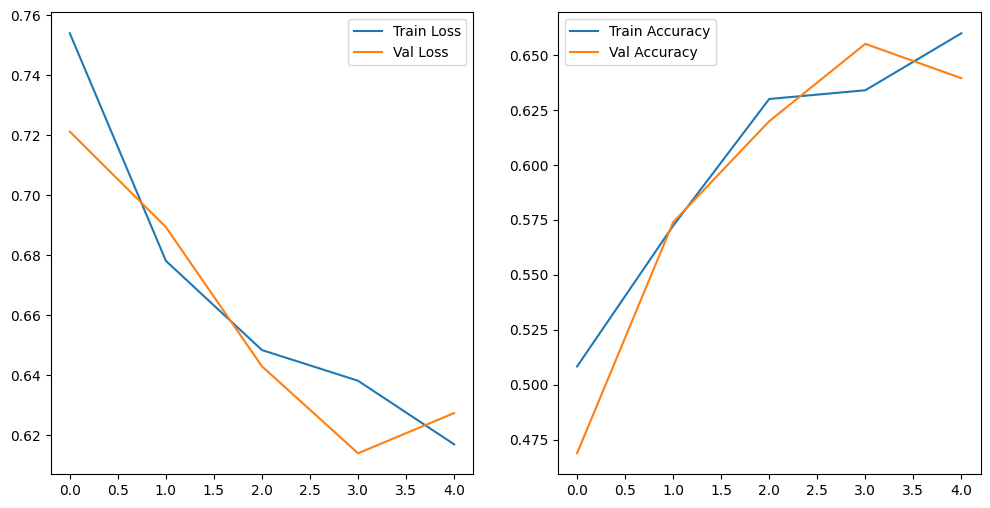

In [24]:
figure = plt.figure(figsize=(12, 6))
cols, rows = 2, 1
for i, (train_plot, val_plot, label) in enumerate([(train_losses, val_losses, "Loss"), (train_accuracies, val_accuracies, "Accuracy")]):
    figure.add_subplot(rows, cols, i+1)
    plt.plot(train_plot, label=f"Train {label}")
    plt.plot(val_plot, label=f"Val {label}")
    plt.legend()

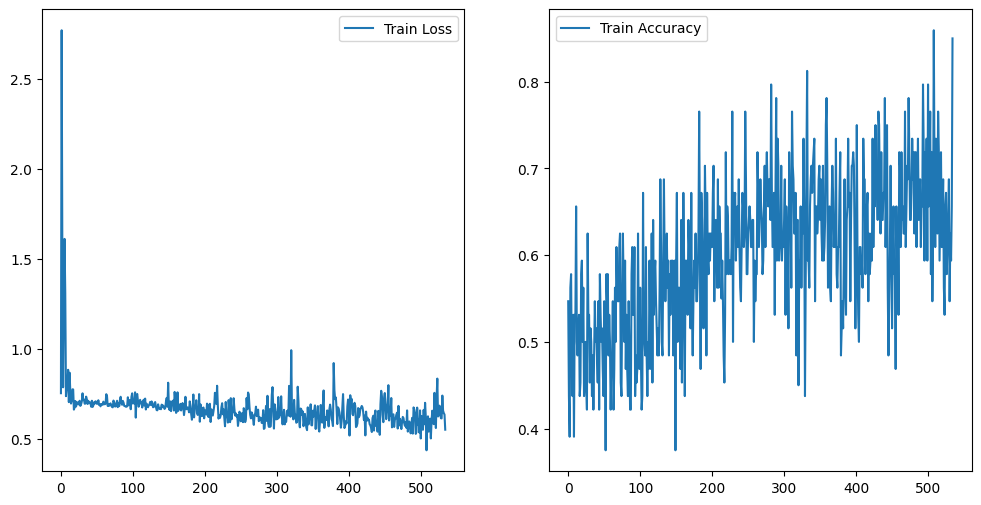

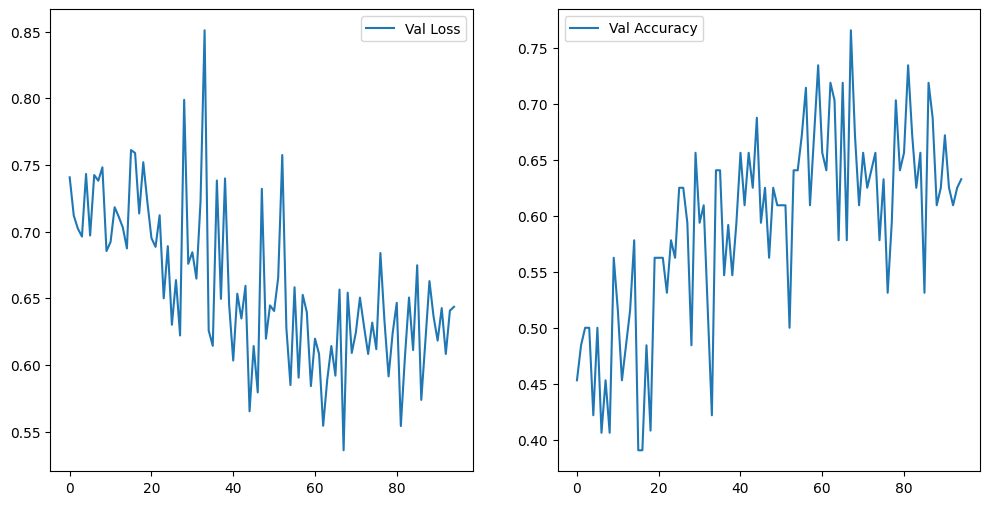

In [34]:
figure = plt.figure(figsize=(12, 6))
cols, rows = 2, 1
for i, (train_plot, label) in enumerate([(steps_train_losses, "Loss"), (steps_train_accuracies, "Accuracy")]):
    figure.add_subplot(rows, cols, i+1)
    plt.plot(train_plot, label=f"Train {label}")
    plt.legend()

figure = plt.figure(figsize=(12, 6))
cols, rows = 2, 1
for i, (val_plot, label) in enumerate([(steps_val_losses, "Loss"), (steps_val_accuracies, "Accuracy")]):
    figure.add_subplot(rows, cols, i+1)
    plt.plot(val_plot, label=f"Val {label}")
    plt.legend()

#### Saving and testing the model

In [26]:
torch.save(model.state_dict(), os.path.join(MODELS_SAVE_DIR, 'vit.pth'))

In [ ]:
saved_model = VIT(IMAGE_SIZE, IMAGE_CHANNELS, PATCH_SIZE, embed_dim=768,
                    num_heads=4, num_layers=4, num_classes=len(classes), mlp_dropout=0.1, bias=False).to(device)
saved_model.load_state_dict(torch.load(os.path.join(MODELS_SAVE_DIR, 'vit.pth')))

In [29]:
test_loss, test_accuracy, preds, targets = test_model(saved_model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

100%|██████████| 32/32 [00:39<00:00,  1.22s/it, accuracy=0.872, loss=0.617]

Test Loss: 0.6172, Test Accuracy: 0.6513


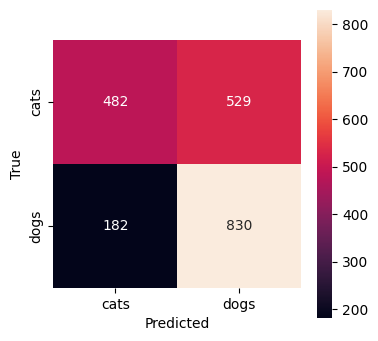

In [40]:
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
print(classification_report(targets, preds, target_names=classes))

              precision    recall  f1-score   support

        cats       0.73      0.48      0.58      1011
        dogs       0.61      0.82      0.70      1012

    accuracy                           0.65      2023
   macro avg       0.67      0.65      0.64      2023
weighted avg       0.67      0.65      0.64      2023

